In [11]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.13 ; cuda:  cu116


In [12]:
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()



In [13]:
data_dir = 'data/hymenoptera_data'
data_transforms = {'train':transforms.Compose([
                  transforms.RandomHorizontalFlip(),
                  transforms.RandomResizedCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                 ]),
                 'val': transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

                
}
train_dataset = datasets.ImageFolder(os.path.join(data_dir,'train'),data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'),data_transforms['val'])
# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


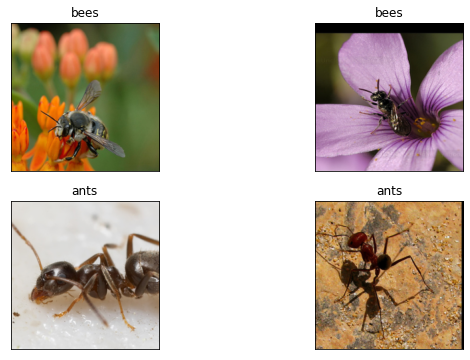

In [14]:
images, labels = next(iter(train_loader))
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    print(image.shape)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

In [15]:

class ResNetSimple(nn.Module):
  def __init__(self):

    super().__init__()
    # Conv 1 layer: (3,224,224) -> (8,112,112)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1)
    # Conv1 layer output size = (W-F+2P)/S+1 = (224-3+2)/2+1 = 112
    # Batch norm
    self.bn1 = nn.BatchNorm2d(8)
    
    ### RESNET BLOCK 1 ###

    # Conv layer: (8,112,112) -> (8,112,112)
    self.block1conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
    # Batch norm
    self.block1bn1 = nn.BatchNorm2d(8)
    # Conv layer: (8,112,112) -> (8,112,112)
    self.block1conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
    # Batch norm
    self.block1bn2 = nn.BatchNorm2d(8)

    ### RESNET BLOCK 2 ###

    # Conv layer: (8,112,112) -> (8,112,112)
    self.block2conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
    # Batch norm
    self.block2bn1 = nn.BatchNorm2d(8)
    # Conv layer: (8,112,112) -> (8,112,112)
    self.block2conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
    # Batch norm
    self.block2bn2 = nn.BatchNorm2d(8)


    self.pool2 = nn.AvgPool2d(kernel_size =7  , stride= 7 )
    self.fcl = nn.Linear(8*16*16,2)
  def forward(self,x):

    x = self.conv1(x)
    x = self.bn1(x)
    x =F.relu(x)

    skipconnect = x

    x_out = self.block1conv1(x)
    x_out = self.block1bn1(x_out)
    x_out  =F.relu(x_out)
    x_out = self.block1conv2(x_out)
    x_out = self.block1bn2(x_out)

    x_out+= skipconnect 
    x_out = F.relu(x_out)


    skipconnect = x_out 
    x_out = self.block2conv1(x)
    x_out = self.block2bn1(x_out)
    x_out  =F.relu(x_out)
    x_out = self.block2conv2(x_out)
    x_out = self.block2bn2(x_out)

    x_out+= skipconnect 
    x_out = F.relu(x_out)
    x_out = self.pool2(x_out)
    x_out = x_out.view(x_out.size(0),-1)
    x_out = self.fcl(x_out)
    return x_out 












In [16]:
net = ResNetSimple()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 112, 112]             224
       BatchNorm2d-2           [4, 8, 112, 112]              16
            Conv2d-3           [4, 8, 112, 112]             584
       BatchNorm2d-4           [4, 8, 112, 112]              16
            Conv2d-5           [4, 8, 112, 112]             584
       BatchNorm2d-6           [4, 8, 112, 112]              16
            Conv2d-7           [4, 8, 112, 112]             584
       BatchNorm2d-8           [4, 8, 112, 112]              16
            Conv2d-9           [4, 8, 112, 112]             584
      BatchNorm2d-10           [4, 8, 112, 112]              16
        AvgPool2d-11             [4, 8, 16, 16]               0
           Linear-12                     [4, 2]           4,098
Total params: 6,738
Trainable params: 6,738
Non-trainable params: 0
-----------------------------------

In [18]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=50):

    model = model.to(device)

    iter_num = {'train':0,'val':0} 

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
            
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)

                iter_num[phase] += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return

In [ ]:
# Instantiate the model
net = ResNetSimple()

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(net.parameters(),  lr=0.001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(net, criterion, optimizer, dataloaders, device, num_epochs=60)

Epoch 0/59
----------
train Loss: 0.8380 Acc: 0.5943
val Loss: 0.8539 Acc: 0.5686
Epoch 1/59
----------
train Loss: 1.0115 Acc: 0.5697
val Loss: 1.3129 Acc: 0.4706
Epoch 2/59
----------
train Loss: 0.8981 Acc: 0.5287
val Loss: 0.7240 Acc: 0.6078
Epoch 3/59
----------
train Loss: 0.8104 Acc: 0.5205
val Loss: 0.7738 Acc: 0.5948
Epoch 4/59
----------
train Loss: 0.7653 Acc: 0.5738
val Loss: 0.7388 Acc: 0.6209
Epoch 5/59
----------
train Loss: 0.6834 Acc: 0.6434
val Loss: 0.6721 Acc: 0.6601
Epoch 6/59
----------
train Loss: 0.7061 Acc: 0.6393
val Loss: 0.6796 Acc: 0.6405
Epoch 7/59
----------
train Loss: 0.6887 Acc: 0.6475
val Loss: 0.9035 Acc: 0.5425
Epoch 8/59
----------
train Loss: 0.6723 Acc: 0.6230
val Loss: 0.7868 Acc: 0.5556
Epoch 9/59
----------
train Loss: 0.6302 Acc: 0.6557
val Loss: 0.7731 Acc: 0.5948
Epoch 10/59
----------
train Loss: 0.6670 Acc: 0.6107
val Loss: 0.7506 Acc: 0.6078
Epoch 11/59
----------
train Loss: 0.6575 Acc: 0.6598
